<a href="https://colab.research.google.com/github/OscarRojasG/CLP-Framework/blob/main/CLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador de instancias

Cada instancia se representa con el siguiente formato:

```
1                   # ID de la instancia
587 233 220         # Dimensiones del contenedor (L W H)
10                  # Número de tipos de cajas
1 108 0 76 0 30 1 20
2 110 0 43 1 25 1 11
3 92 1 81 1 55 1 9
4 81 0 33 1 28 1 9
5 120 1 99 1 73 1 9
6 111 0 70 1 48 1 13
7 98 0 72 1 46 1 4
8 95 0 66 0 31 1 12
9 85 0 84 0 30 1 9
10 71 0 32 1 25 1 10
```

Cada tipo de caja se describe en una línea con el siguiente formato:

```
id_caja  L  rotX  W  rotY  H  rotZ  cantidad
1 108 0 76 0 30 1 20
```

Donde:

* $L, W, H$ son las dimensiones de la caja
* $rotX, rotY, rotZ$ es la factibilidad de que cada caja pueda ser rotada sobre los ejes X, Y, Z.

In [ ]:
from typing import List
import random

class BoxType:
    def __init__(self, box_id, dims, rots, qty):
        self.id = box_id        # identificador de la caja
        self.dims = dims        # (L, W, H)
        self.rots = rots        # (rotX, rotY, rotZ)
        self.qty = qty          # cantidad de cajas


class CLPInstance:
    def __init__(self, container, boxes : list[BoxType]):
        self.container = container  # (L, W, H)
        self.n_types = len(boxes)
        self.boxes = boxes          # lista de BoxType


def instance(n_types=10, seed=None):
    """
    Genera una sola instancia del CLP como objeto CLPInstance.
    """
    if seed is not None:
        random.seed(seed)

    # Dimensiones del contenedor (fijas en este caso)
    l, w, h = 587, 233, 220

    # Límites de dimensiones de las cajas
    alpha = [30, 25, 20]   # mínimo largo, ancho, alto
    beta  = [120, 100, 80] # máximo largo, ancho, alto
    L = 2  # constante de estabilidad

    # Volumen del contenedor
    tc = l * w * h

    dimension_box = []
    cantidad_box_type = []
    volumen_box_type = []
    orientacion_box = []

    # Genera tipos de cajas
    for i in range(n_types):
        # Dimensiones aleatorias dentro de los rangos
        r_j = [random.randint(alpha[j], beta[j]) for j in range(3)]
        aux_dim = [alpha[j] + (r_j[j] % (beta[j] - alpha[j] + 1)) for j in range(3)]
        dimension_box.append(aux_dim)

        # Inicializa cantidad
        cantidad_box_type.append(1)

        # Volumen de la caja
        volumen_box_type.append(aux_dim[0] * aux_dim[1] * aux_dim[2])

        # Orientación factible según la constante L
        min_dim = min(aux_dim)
        aux_orient = [1 if aux_dim[j] / min_dim < L else 0 for j in range(3)]
        orientacion_box.append(aux_orient)

    # Rellena hasta que no quepa más
    volumen_cargo = 0
    while True:
        volumen_cargo = sum(cantidad_box_type[i] * volumen_box_type[i] for i in range(n_types))
        aux = random.randint(0, n_types - 1)
        v_k = volumen_box_type[aux]
        if tc > volumen_cargo + v_k:
            cantidad_box_type[aux] += 1
        else:
            break

    # Construye lista de BoxType
    boxes = [
        BoxType(i + 1, dimension_box[i], orientacion_box[i], cantidad_box_type[i])
        for i in range(n_types)
    ]

    return CLPInstance(container=(l, w, h), boxes=boxes)


def gen_instances(filename, n_instances=100, n_types=10, seed=None):
    """
    Genera un archivo con varias instancias CLP en el formato definido.
    """
    with open(filename, "w") as f:
        # número total de instancias
        f.write(str(n_instances) + "\n")

        for inst_id in range(1, n_instances + 1):
            inst = instance(n_types=n_types, seed=(seed + inst_id) if seed is not None else None)

            # encabezado de la instancia
            f.write(f"{inst_id}\n")
            l, w, h = inst.container
            f.write(f"{l} {w} {h}\n")
            f.write(f"{inst.n_types}\n")

            # tipos de cajas
            for i, box in enumerate(inst.boxes):
                Lc, Wc, Hc = box.dims
                rotX, rotY, rotZ = box.rots
                qty = box.qty

                if inst_id == n_instances and i == len(inst.boxes) - 1:
                    f.write(f"{box.id} {Lc} {rotX} {Wc} {rotY} {Hc} {rotZ} {qty}")
                else:
                    f.write(f"{box.id} {Lc} {rotX} {Wc} {rotY} {Hc} {rotZ} {qty}\n")

def read_instances(filename) -> list[CLPInstance]:
    """
    Lee un archivo de instancias CLP y devuelve una lista de objetos CLPInstance.
    """
    instances = []
    with open(filename, "r") as f:
        # número total de instancias
        n_instances = int(f.readline().strip())

        for _ in range(n_instances):
            inst_id = int(f.readline().split()[0])  # id de la instancia

            # dimensiones del contenedor
            l, w, h = map(int, f.readline().split())

            # número de tipos de cajas
            n_types = int(f.readline().strip())

            boxes = []
            for _ in range(n_types):
                parts = f.readline().split()
                box_id = int(parts[0])
                Lc = int(parts[1])
                rotX = int(parts[2])
                Wc = int(parts[3])
                rotY = int(parts[4])
                Hc = int(parts[5])
                rotZ = int(parts[6])
                qty = int(parts[7])

                boxes.append(BoxType(box_id, (Lc, Wc, Hc), (rotX, rotY, rotZ), qty))

            instances.append(CLPInstance(container=(l, w, h), boxes=boxes))

    return instances

In [ ]:
gen_instances("prueba.txt", n_instances=5, n_types=10, seed=1)
read_instances("prueba.txt")

# BSG-VCS

Al ejecutar

```
./BSG_CLP prueba.txt -i 1 -t 10 --verbose2=5 > output.txt
```

se guardarán los bloques seleccionados por BSG para construir la solución, en conjunto con los $m=5$ bloques más prometedores para cada estado:

```
selected block:686 space:(362,0,103)
  action block:686 eval: 752760 0.024314749 0.85935438 0.16666667 279914.38
  action block:600 eval: 752760 0.1954876 0.76418638 0.16666667 144329.86
  action block:147 eval: 376380 0.024314749 0.79643276 0.33333333 118606.5
  action block:149 eval: 501840 0.024314749 0.73896542 0.25 110652.05
  action block:123 eval: 501840 0.11661384 0.74613438 0.25 104129.09
```

Los valores a continuación de `eval` indican las métricas:

```
eval: V Loss CS 1/n VCS
```

Nótese que en algunos casos, el bloque elegido por BSG no está dentro de los $m$ más prometedores. Estos casos son de particular relevancia ya que la heurística "falla" en su evaluación. En estos casos se imprime un sexto bloque:

```
selected block:141 space:(282,169,113)
  action block:2318 eval: 825600 0.068243858 0.68818263 0.2 125052.61
  action block:550 eval: 495360 0.041233657 0.66613802 0.33333333 75069.99
  action block:553 eval: 660480 0.055983909 0.60071472 0.25 61531.879
  action block:568 eval: 660480 0.26440305 0.61178143 0.25 51578.982
  action block:17 eval: 194532 0.007518797 0.70680679 1 48185.48
  action block:141 eval: 330240 0.01910828 0.62544895 0.5 43153.121
```


In [ ]:
%cd /content
!chmod +x BSG_CLP
!./BSG_CLP prueba.txt -i 1 -t 10 --verbose2=500 > output.txt

/content
Flag could not be matched: 't'
  ./BSG_CLP {OPTIONS} [instance-set]

    ********* BSG-CLP *********.

  OPTIONS:

      -h, --help                        Display this help menu
      -i[int]                           Instance
      -f[string]                        Format: (BR, BRw, 1C)
      --min_fr=[double]                 Minimum volume occupied by a block
                                        (proportion)
      -w[int]                           Beam width (nodes per level)
      --seed=[int]                      Random seed
      --alpha=[double]                  Alpha parameter
      --beta=[double]                   Beta parameter
      --gamma=[double]                  Gamma parameter
      --delta=[double]                  Delta parameter
      -p[double]                        p parameter
      --json                            json output tuple
      --verbose                         Show the actions to reach the solution
      --verbose2=[layout]               V

In [1]:
import re

def parse_file(file_path):
    results = []
    current_block = None

    re_selected = re.compile(r"selected block:(\d+)\s+space:\((\d+),(\d+),(\d+)\)")
    re_action = re.compile(r"action block:(\d+)\s+eval:\s+([0-9eE+.\s\-infINF]+)")

    # Abrimos el archivo y leemos su contenido
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # selected block
            m_sel = re_selected.match(line)
            if m_sel:
                if current_block:
                    results.append(current_block)
                block_id = int(m_sel.group(1))
                coords = tuple(map(int, m_sel.groups()[1:]))
                current_block = (block_id, coords, [])
                continue

            # action block
            m_act = re_action.match(line)
            if m_act and current_block:
                act_id = int(m_act.group(1))
                tokens = m_act.group(2).split()
                nums = []
                for tok in tokens:
                    try:
                        nums.append(float(tok))
                    except ValueError:
                        # fallback por si aparece algo inesperado
                        nums.append(float("nan"))
                current_block[2].append((act_id, nums))

    if current_block:
        results.append(current_block)

    return results



from collections import Counter

def selected_block_positions(data):
    positions = []

    for sel_id, coords, actions in data:
        for idx, (act_id, _) in enumerate(actions, start=1):  # índice 1-based
            if act_id == sel_id:
                positions.append(idx)
                break  # solo interesa la primera coincidencia

    # contamos frecuencia de cada posición
    freq = Counter(positions)

    # rango completo de 1 .. max
    max_pos = max(freq) if freq else 0
    result = [(i, freq.get(i, 0)) for i in range(1, max_pos + 1)]

    return result



def expand_to_x(arr, x):
    # Usamos un diccionario para mapear ids a sus frecuencias
    expanded_dict = dict(arr)

    # Asegurarse de que todos los ids hasta x estén presentes
    for i in range(1, x + 1):
        if i not in expanded_dict:
            expanded_dict[i] = 0

    # Convertimos el diccionario de nuevo a una lista de tuplas y la ordenamos
    expanded_arr = sorted(expanded_dict.items())

    return expanded_arr


import subprocess
import os

def run_instance(exe_path, file_path, i, w, output_path=None):
    """Ejecuta BSG_CLP para una instancia y guarda la salida en un archivo .out dentro de una carpeta específica o en la misma ruta que file_path"""

    # Si output_path es None, usar la misma carpeta que file_path
    if output_path is None:
        output_path = os.path.dirname(file_path)

    # Obtener el nombre base de file_path sin la extensión
    base_filename = os.path.splitext(os.path.basename(file_path))[0]

    # Generar el nombre del archivo de salida con 'i' y extensión .out
    output_file_path = os.path.join(output_path, f"{base_filename}-{i}.out")

    # Ejecutar el proceso y capturar la salida
    proc = subprocess.run(
        [exe_path, file_path, "-i", str(i), "-w", str(w), f"--verbose2={str(w*w)}"],
        stdout=subprocess.PIPE,
        stderr=subprocess.DEVNULL,
        check=True,
        text=True
    )

    # Guardar la salida en el archivo de salida
    with open(output_file_path, 'w') as f:
        f.write(proc.stdout)



from concurrent.futures import ProcessPoolExecutor

def run_file_instances_parallel(file_path, exe_path="./BSG_CLP", w=8, max_workers=None):
    # Leer número de instancias
    with open(file_path, "r") as f:
        num_instances = int(f.readline().strip())

    # Crear la carpeta de salida con el nombre del archivo (sin la extensión) y añadir ".out" al final
    output_folder = os.path.splitext(os.path.basename(file_path))[0] + ".out"  # Usamos el nombre del archivo sin la extensión y añadimos ".out"
    os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe

    # Ejecutar las instancias en paralelo
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for i in range(num_instances):
            executor.submit(run_instance, exe_path, file_path, i, w, output_folder)


import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_percentage(result):
    # Convertir a arrays
    positions = np.array([pos for pos, _ in result])
    freqs = np.array([freq for _, freq in result])

    # Frecuencia acumulada porcentual
    cum_freq = np.cumsum(freqs)
    cum_percent = cum_freq / cum_freq[-1] * 100

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.plot(positions, cum_percent)
    plt.xticks(range(0, positions.max() + 10, 10))
    plt.xlabel("Posición")
    plt.ylabel("Frecuencia acumulada (%)")
    plt.title("Frecuencia acumulada porcentual por posición")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


import os
from collections import defaultdict
from math import log, inf

def accumulate_results_from_folder(folder_path):
    # Usamos un defaultdict para acumular los contadores
    total_counts = defaultdict(int)

    # Iterar sobre todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Verificar si es un archivo y si termina en ".out" (puedes ajustarlo si es necesario)
        if os.path.isfile(file_path) and file_path.endswith(".out"):
            # Parsear el archivo y obtener el resultado
            data = parse_file(file_path)
            result = selected_block_positions(data)

            # Acumular los resultados
            for block_id, count in result:
                total_counts[block_id] += count

    # Convertir el defaultdict en una lista de tuplas ordenada por 'id'
    accumulated_result = sorted(total_counts.items())

    return accumulated_result


import numpy as np
from math import log

def generate_train_data(data, pad=64):
    X = []  # Para los datos de entrenamiento
    Y = []  # Para las predicciones (vectores one-hot)
    block_ids = []  # Para las ids de los bloques

    # Recorremos cada bloque
    for block in data:
        # Extraemos las características del bloque (el tercer elemento en cada bloque)
        features = [entry[1][:4] for entry in block[2]]  # Obtiene las características de cada tupla en el bloque

        # Rellenamos con ceros si el número de características es menor que pad
        while len(features) < pad:
            features.append([0.0] * len(features[0]))  # Añadir una lista de ceros de la misma longitud que las características

        # Añadimos las características de este bloque a X
        X.append(features[:pad])  # Aseguramos que no se sobrepasen los "pad" elementos

        # Extraemos el id del bloque (primer valor de la tupla)
        block_id = block[0]

        # Crear el vector one-hot para Y
        one_hot = [0] * pad  # Inicializa un vector con ceros

        # Encontrar la posición de block_id en las tuplas de cada bloque
        for i, entry in enumerate(block[2]):
            if entry[0] == block_id:  # Compara el id de la tupla con el id del bloque
                one_hot[i] = 1  # Marca la posición correspondiente en el vector one-hot
                break

        # Rellenamos con ceros si la longitud de one_hot es menor que pad
        while len(one_hot) < pad:
            one_hot.append(0)  # Añadir ceros al final si hace falta

        # Añadir el vector one-hot a Y
        Y.append(one_hot[:pad])  # Aseguramos que no se sobrepasen los "pad" elementos

        # Añadir las ids del bloque a block_ids y rellenar con ceros si es necesario
        ids = [entry[0] for entry in block[2]]  # Extrae solo el ID de cada tupla
        while len(ids) < pad:
            ids.append(0)  # Rellenar con ceros hasta alcanzar "pad"
        block_ids.append(ids[:pad])  # Aseguramos que no se sobrepasen los "pad" elementos

    return X, Y, block_ids


import os
import pickle

def generate_data_from_folder(folder_path, pad=64):
    all_X = []  # Lista para almacenar todos los datos de entrenamiento
    all_Y = []  # Lista para almacenar todos los vectores one-hot
    all_block_ids = []  # Lista para almacenar todos los block_ids

    # Iterar sobre todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path):  # Solo procesar archivos (no directorios)
            # Parsear el archivo
            data = parse_file(file_path)

            # Generar los datos de entrenamiento
            X, Y, block_ids = generate_train_data(data, pad=pad)

            # Agregar los datos del archivo actual a las listas generales
            all_X.extend(X)
            all_Y.extend(Y)
            all_block_ids.extend(block_ids)

    # Definir el nombre del archivo de salida basado en el nombre de la carpeta
    folder_name = os.path.basename(folder_path)  # Obtiene el nombre de la carpeta
    output_filename = folder_name.split('.')[0] + ".data"  # Eliminar la extensión .out si está presente y agregar .data
    output_path = os.path.join(os.path.dirname(folder_path), output_filename)  # Guardar el archivo en el nivel superior

    # Guardar los datos en el archivo (en este caso, usaremos pickle para guardar en formato binario)
    with open(output_path, "wb") as f:
        pickle.dump({"X": all_X, "Y": all_Y, "block_ids": all_block_ids}, f)

    print(f"Datos guardados en: {output_path}")
    return output_path


def load_data_from_file(file_path):
    # Abrir el archivo .data y cargar los datos
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # Extraer X, Y y block_ids
    X = data["X"]
    Y = data["Y"]
    block_ids = data["block_ids"]

    return X, Y, block_ids


def split_and_save_datasets(file_path, cuts, output_path):
    """Separa los datos en varios datasets según los cortes y guarda en archivos .data"""

    # Añadir un "1" al principio del arreglo cuts para asegurar que el primer dataset sea considerado
    cuts = [1] + cuts

    # Asegurarse de que la carpeta de salida exista
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Cargar los datos desde el archivo .data
    print(f"Procesando archivo: {file_path}")
    X, Y, block_ids = load_data_from_file(file_path)

    # Crear un diccionario para almacenar los datasets
    datasets = {i: {"X": [], "Y": [], "block_ids": []} for i in range(1, len(cuts))}

    # Separar los datos según los cortes
    for i, y_vector in enumerate(Y):
        pos = y_vector.index(1)  # Encontrar la posición del 1 en el vector one-hot

        # Asignar el dato al dataset correspondiente según el corte
        for j in range(len(cuts)-1):
            if pos < cuts[j+1]:
                datasets[j + 1]["X"].append(X[i])
                datasets[j + 1]["Y"].append(Y[i])
                datasets[j + 1]["block_ids"].append(block_ids[i])
                break  # Una vez asignado, salir del loop de cortes

    # Guardar cada dataset en un archivo
    for i, dataset in datasets.items():
        # Generar el nombre del archivo con base en el corte
        start_cut = cuts[i-1] + 1 if i > 1 else 1
        end_cut = cuts[i]  # Cortes entre `cuts[i-1]` y `cuts[i]`

        output_filename = f"{start_cut}-{end_cut}.data"
        output_file_path = os.path.join(output_path, output_filename)

        # Guardar el dataset en el archivo
        with open(output_file_path, "wb") as f:
            pickle.dump({"X": dataset["X"], "Y": dataset["Y"], "block_ids": dataset["block_ids"]}, f)

        print(f"Dataset guardado en: {output_file_path}")


def remove_elements_with_zero(X, Y, blocks_ids):
    # Crear una lista de índices a eliminar
    indices_to_remove = []

    # Recorre blocks_ids y encuentra los índices que contienen al menos un 0
    for idx, arr in enumerate(blocks_ids):
        if 0 in arr:
            indices_to_remove.append(idx)

    # Eliminar los elementos en X, Y y blocks_ids correspondientes a los índices encontrados
    X_filtered = [x for i, x in enumerate(X) if i not in indices_to_remove]
    Y_filtered = [y for i, y in enumerate(Y) if i not in indices_to_remove]
    blocks_ids_filtered = [block for i, block in enumerate(blocks_ids) if i not in indices_to_remove]

    return X_filtered, Y_filtered, blocks_ids_filtered

In [ ]:
!git clone https://github.com/rilianx/Metasolver.git

Cloning into 'Metasolver'...
remote: Enumerating objects: 60593, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 60593 (delta 186), reused 161 (delta 160), pack-reused 60363 (from 3)
Receiving objects: 100% (60593/60593), 573.42 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (8796/8796), done.
Updating files: 100% (7475/7475), done.


In [ ]:
run_file_instances_parallel("Metasolver/problems/clp/benchs/BR/BR1.txt", exe_path="./BSG_CLP", w=8)

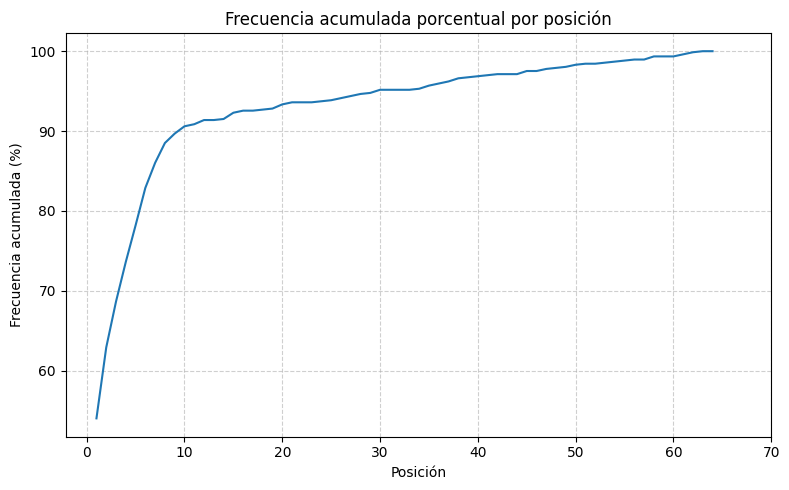

In [ ]:
acumr = accumulate_results_from_folder("BR1.out")
acumr = expand_to_x(acumr, 64)
plot_cumulative_percentage(acumr)

In [ ]:
data = parse_file("BR1.out/BR1-0.out")
generate_train_data(data, pad=64)

In [ ]:
# Ejemplo de uso
folder_path = "BR1.out"  # Carpeta que contiene los archivos
generate_data_from_folder(folder_path, pad=64)

In [ ]:
X, Y, blocks_ids = load_data_from_file("BR1.data")
print(len(X))
print(len(Y))
print(len(blocks_ids))

In [ ]:
# Ejemplo de uso
file_path = "BR1.data"  # Archivo .data de entrada
output_path = "BR1-datasets"  # Carpeta donde se guardarán los nuevos datasets
cuts = [1, 7, 64]  # Los cortes

split_and_save_datasets(file_path, cuts, output_path)

Procesando archivo: BR1.data
Dataset guardado en: BR1-datasets/1-1.data
Dataset guardado en: BR1-datasets/2-7.data
Dataset guardado en: BR1-datasets/8-64.data


In [ ]:
X, Y, blocks_ids = load_data_from_file("BR1-datasets/1-1.data")
len(X)

414

In [ ]:
gen_instances("E4.txt", n_instances=1000, n_types=10, seed=42)

In [ ]:
run_file_instances_parallel("E4.txt", exe_path="./BSG_CLP", w=8)

KeyboardInterrupt: 

In [ ]:
generate_data_from_folder("E4.out", pad=64)

Datos guardados en: E4.data


'E4.data'

In [ ]:
split_and_save_datasets("E4.data", [1, 7, 64], "E4-datasets")

Procesando archivo: E4.data
Dataset guardado en: E4-datasets/1-1.data
Dataset guardado en: E4-datasets/2-7.data
Dataset guardado en: E4-datasets/8-64.data


In [ ]:
X, Y, blocks_ids = load_data_from_file("E4-datasets/1-1.data")
len(X)

11387

In [ ]:
Xf, Yf, bf = remove_elements_with_zero(X, Y, blocks_ids)
len(Xf)

4593

In [ ]:
!zip -r E4-datasets.zip E4-datasets

  adding: E4-datasets/ (stored 0%)
  adding: E4-datasets/2-7.data (deflated 73%)
  adding: E4-datasets/8-64.data (deflated 68%)
  adding: E4-datasets/1-1.data (deflated 81%)


In [2]:
!unzip E4-datasets.zip

Archive:  E4-datasets.zip
   creating: E4-datasets/
  inflating: E4-datasets/2-7.data    
  inflating: E4-datasets/8-64.data   
  inflating: E4-datasets/1-1.data    


# Modelo y entrenamiento

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CLPModel(nn.Module):
    def __init__(self, input_dim, num_heads, head_dim, num_layers=2, dropout_rate=0):
        super(CLPModel, self).__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim

        # Proyección de entrada
        self.input_projection = nn.Linear(input_dim, num_heads * head_dim)

        # Crear múltiples capas de atención y densa
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'multihead_attention': nn.MultiheadAttention(
                    embed_dim=num_heads * head_dim,
                    num_heads=num_heads,
                    dropout=dropout_rate
                ),
                'dense_layer': nn.Sequential(
                    nn.Linear(num_heads * head_dim, 512),
                    nn.ReLU(),
                    nn.Linear(512, num_heads * head_dim)
                ),
                'norm1': nn.LayerNorm(num_heads * head_dim),
                'norm2': nn.LayerNorm(num_heads * head_dim)
            }) for _ in range(num_layers)
        ])

        # Proyección de salida final
        self.output_projection = nn.Linear(num_heads * head_dim, 1)

    def generate_attention_mask(self, x, num_heads, padding_value=0):
        # Identificar posiciones de padding en x
        mask = (x.sum(dim=-1) == padding_value)  # [batch_size, seq_length]
        mask = mask.unsqueeze(1).expand(-1, x.size(1), -1)
        mask = mask.unsqueeze(1).expand(-1, num_heads, -1, -1)
        mask = mask.reshape(-1, x.size(1), x.size(1))
        mask = mask.to(dtype=torch.bool)
        return mask

    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        x = x.float()

        # Proyección de entrada
        x_proj = self.input_projection(x)

        # Generar máscara de atención
        attn_mask = self.generate_attention_mask(x, self.num_heads)

        # Aplicar cada capa de atención y densa
        for layer in self.layers:
            x_proj = x_proj.permute(1, 0, 2)
            attn_output, _ = layer['multihead_attention'](
                x_proj, x_proj, x_proj, attn_mask=attn_mask
            )
            attn_output = attn_output.permute(1, 0, 2)
            x_proj = x_proj.permute(1, 0, 2)
            attn_output = layer['norm1'](attn_output + x_proj)
            dense_output = layer['dense_layer'](attn_output)
            x_proj = layer['norm2'](dense_output + attn_output)

        # Máscara para softmax
        mask = torch.zeros_like(x, dtype=torch.bool)
        mask = (x * ~mask).sum(dim=-1) == 0
        mask = mask.to(dtype=torch.bool)

        # Proyección de salida final (logits)
        output = self.output_projection(x_proj)  # [batch_size, seq_length, num_classes]

        # Flatten
        flat_output = output.view(output.size(0), -1)  # [batch_size, seq_length]

        # Enmascarar los logits antes de la pérdida: asignar un valor muy negativo a los logits en las posiciones no válidas
        flat_output = flat_output.masked_fill(mask, -1e9)  # Asignar un valor muy negativo a las posiciones no válidas

        return flat_output  # Retorna los logits (sin aplicar softmax)


# Parámetros del modelo
input_dim = 5  # Dimensión de la entrada
num_heads = 8  # Número de cabezas en la atención multi-cabeza
head_dim = 16  # Dimensión de cada cabeza
num_layers = 6  # Número de capas

# Crear el modelo
model = CLPModel(input_dim=input_dim, num_heads=num_heads, head_dim=head_dim, num_layers=num_layers)

# Información del modelo
print(model)

CLPModel(
  (input_projection): Linear(in_features=5, out_features=128, bias=True)
  (layers): ModuleList(
    (0-5): 6 x ModuleDict(
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (dense_layer): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_projection): Linear(in_features=128, out_features=1, bias=True)
)


In [4]:
X, Y, blocks_ids = load_data_from_file("E4-datasets/1-1.data")
X, Y, _ = remove_elements_with_zero(X, Y, blocks_ids)
X = torch.tensor(X[:500])
Y = torch.tensor(Y[:500])

print(X.shape, Y.shape)

torch.Size([500, 64, 4]) torch.Size([500, 64])


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(X, Y)

# Dividir el dataset en entrenamiento y prueba
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

AttributeError: 'list' object has no attribute 'size'

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir el modelo, la función de pérdida y el optimizador
loss_function = torch.nn.CrossEntropyLoss()  # Pérdida sin reducción
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Ciclo de entrenamiento
epochs = 1

history = {split: {'loss': [], 'acc': []} for split in ['train', 'val']}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0; total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Limpia los gradientes
        outputs = model(X_batch)  # Obtenemos logits

        # Calcular la pérdida para cada elemento en el batch
        loss = loss_function(outputs, y_batch.argmax(dim=-1))

        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar parámetros

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch.argmax(dim=1)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    history['train']['loss'].append(train_loss)
    history['train']['acc'].append(train_accuracy)

    # Validación
    model.eval()
    validation_loss = 0
    correct = 0; total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Obtenemos logits

            # Calcular la pérdida para cada elemento en el batch (sin reducción)
            loss = loss_function(outputs, y_batch.argmax(dim=-1))

            validation_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch.argmax(dim=1)).sum().item()

    validation_loss /= len(test_loader.dataset)
    validation_accuracy = 100 * correct / total
    history['val']['loss'].append(validation_loss)
    history['val']['acc'].append(validation_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Epoch {epoch+1}, Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%')

NameError: name 'train_dataset' is not defined

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from math import log

def normalize_input(X):
    # features = [V, Loss, CS, 1/n]

    # Pasar a escala logarítmica
    '''
    for input in X:
        for fvector in input:
            # Convertir Loss a (1 - Loss)
            fvector[1] = 1 - fvector[1]

            for i in range(len(fvector)):
                fvector[i] = log(fvector[i], 10) if fvector[i] > 0 else 999999
    '''

    # Escalar con StandardScaler
    # X shape: [num_ejemplos, num_acciones, 4]
    X = np.array(X, dtype=np.float32)

    # Aplano a 2D
    X_flat = X.reshape(-1, X.shape[-1])  # [num_ejemplos*num_acciones, 4]

    # Fit/transform
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)

    # Vuelvo a la forma original
    X = X_scaled.reshape(-1, X.shape[1], X.shape[2])
    return X


def curriculum_learning(model, datasets, epochs, weights, train_size, test_size, batch_size, learning_rate):
    # Cargar los datasets
    data = []
    for dataset in datasets:
        X, Y, blocks_ids = load_data_from_file(dataset)
        X, Y, _ = remove_elements_with_zero(X, Y, blocks_ids)
        X = normalize_input(X)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        data.append((X, Y))

    # Inicializar el modelo, la función de pérdida y el optimizador
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Histórico de métricas
    history = {split: {'loss': [], 'acc': []} for split in ['train', 'val']}

    # Ciclo de entrenamiento por fases
    for phase_idx in range(len(datasets)):
        # Determinar la distribución de los datasets por fase
        total_weight = sum(weights[:phase_idx + 1])
        weights_normalized = [w / total_weight for w in weights[:phase_idx + 1]]

        # Crear DataLoaders para los datasets de la fase
        train_loader_list = []
        test_loader_list = []

        # Para cada dataset en la fase, usar su peso para determinar la cantidad de muestras
        for idx, (X, Y) in enumerate(data[:phase_idx + 1]):
            weight = weights_normalized[idx]

            # Número de muestras para el conjunto de entrenamiento y validación (según peso)
            num_train_samples = int(weight * train_size)
            num_test_samples = int(weight * test_size)

            # Crear un dataset general
            dataset = TensorDataset(X, Y)

            # Separar los datos para entrenamiento y prueba sin solapamiento
            # Primero obtenemos el conjunto de entrenamiento
            train_dataset, remaining_dataset = random_split(dataset, [num_train_samples, len(dataset) - num_train_samples])

            # Luego, del resto de datos, obtenemos el conjunto de prueba
            test_dataset, _ = random_split(remaining_dataset, [num_test_samples, len(remaining_dataset) - num_test_samples])

            # Crear los DataLoader para cada dataset
            train_loader_list.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
            test_loader_list.append(DataLoader(test_dataset, batch_size=batch_size, shuffle=False))

        # Ciclo de entrenamiento para cada fase
        for epoch in range(epochs[phase_idx]):
            model.train()
            train_loss = 0
            correct = 0
            total = 0

            # Combinar los datos de los datasets para el conjunto de entrenamiento
            current_train_loader = []
            for loader in train_loader_list:
                current_train_loader.extend(loader)

            # Entrenamiento
            for X_batch, y_batch in current_train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch.argmax(dim=-1))
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.argmax(dim=1)).sum().item()

            train_loss /= total  # Promedio de la pérdida
            train_accuracy = 100 * correct / total
            history['train']['loss'].append(train_loss)
            history['train']['acc'].append(train_accuracy)

            # Validación
            model.eval()
            validation_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                current_test_loader = []
                for loader in test_loader_list:
                    current_test_loader.extend(loader)

                for X_batch, y_batch in current_test_loader:
                    outputs = model(X_batch)
                    loss = loss_function(outputs, y_batch.argmax(dim=-1))
                    validation_loss += loss.item() * X_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch.argmax(dim=1)).sum().item()

            validation_loss /= total
            validation_accuracy = 100 * correct / total
            history['val']['loss'].append(validation_loss)
            history['val']['acc'].append(validation_accuracy)

            print(f'Epoch {epoch + 1}/{epochs[phase_idx]}, Phase {phase_idx + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
            print(f'Epoch {epoch + 1}/{epochs[phase_idx]}, Phase {phase_idx + 1} - Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%')

    return history

In [9]:
# Parámetros del modelo
input_dim = 4  # Dimensión de la entrada
num_heads = 8  # Número de cabezas en la atención multi-cabeza
head_dim = 16  # Dimensión de cada cabeza
num_layers = 6  # Número de capas

# Crear el modelo
model = CLPModel(input_dim=input_dim, num_heads=num_heads, head_dim=head_dim, num_layers=num_layers)

In [13]:
datasets = ["E4-datasets/1-1.data", "E4-datasets/2-7.data", "E4-datasets/8-64.data"]
epochs = [0, 20, 0]
weights = [4, 1, 1]
train_size = 1200
test_size = 300
batch_size = 32
learning_rate = 1e-4

curriculum_learning(model, datasets, epochs, weights, train_size, test_size, batch_size, learning_rate)

Epoch 1/20, Phase 2 - Train Loss: 1.4759, Train Accuracy: 73.33%
Epoch 1/20, Phase 2 - Val Loss: 1.2945, Val Accuracy: 66.33%
Epoch 2/20, Phase 2 - Train Loss: 1.2145, Train Accuracy: 73.42%
Epoch 2/20, Phase 2 - Val Loss: 1.1686, Val Accuracy: 67.67%
Epoch 3/20, Phase 2 - Train Loss: 1.2162, Train Accuracy: 73.50%
Epoch 3/20, Phase 2 - Val Loss: 1.0980, Val Accuracy: 68.67%
Epoch 4/20, Phase 2 - Train Loss: 1.1830, Train Accuracy: 74.42%
Epoch 4/20, Phase 2 - Val Loss: 1.1203, Val Accuracy: 69.00%
Epoch 5/20, Phase 2 - Train Loss: 1.2407, Train Accuracy: 74.83%
Epoch 5/20, Phase 2 - Val Loss: 1.1383, Val Accuracy: 68.33%
Epoch 6/20, Phase 2 - Train Loss: 1.2236, Train Accuracy: 73.67%
Epoch 6/20, Phase 2 - Val Loss: 1.1862, Val Accuracy: 67.33%
Epoch 7/20, Phase 2 - Train Loss: 1.1902, Train Accuracy: 74.42%
Epoch 7/20, Phase 2 - Val Loss: 1.1103, Val Accuracy: 68.00%
Epoch 8/20, Phase 2 - Train Loss: 1.1299, Train Accuracy: 75.50%
Epoch 8/20, Phase 2 - Val Loss: 1.1242, Val Accuracy:

{'train': {'loss': [1.4759207248687745,
   1.2144553073247273,
   1.2162444837888082,
   1.1830488626162212,
   1.2407187481721242,
   1.2235941394170124,
   1.1902378837267558,
   1.1299270296096802,
   1.1201626014709474,
   1.114825999736786,
   1.110683526992798,
   1.0757223645846048,
   1.0925645661354064,
   1.0838728332519532,
   1.0694393765926362,
   1.1044625250498454,
   1.0277729475498198,
   1.063039231300354,
   1.010594958861669,
   0.9964226281642914],
  'acc': [73.33333333333333,
   73.41666666666667,
   73.5,
   74.41666666666667,
   74.83333333333333,
   73.66666666666667,
   74.41666666666667,
   75.5,
   75.58333333333333,
   76.0,
   75.75,
   76.0,
   75.91666666666667,
   75.25,
   77.16666666666667,
   76.33333333333333,
   76.91666666666667,
   77.25,
   76.75,
   77.41666666666667]},
 'val': {'loss': [1.2944805749257406,
   1.1686315822601319,
   1.097958917617798,
   1.1203376865386963,
   1.138338181177775,
   1.1862380282084146,
   1.1102726904551188,
   

# Ejecutable (testing)

In [ ]:
!git clone https://github.com/rilianx/Metasolver.git

In [ ]:
!cmake .
!make

In [ ]:
!./BSG_CLP --help

In [ ]:
!./BSG_CLP prueba.txt -i 1 -w 8 --verbose2=64